# Module Import

In [1]:
from mplug_owl.modeling_mplug_owl import MplugOwlForConditionalGeneration
from mplug_owl.tokenization_mplug_owl import MplugOwlTokenizer
from mplug_owl.processing_mplug_owl import MplugOwlImageProcessor, MplugOwlProcessor
import torch
from PIL import Image
import json
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

/home/livin/anaconda3/envs/mplug/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


install flash-attn first.


# Model, Tokenizer Load

In [2]:
pretrained_ckpt = 'MAGAer13/mplug-owl-llama-7b'
# pretrained_ckpt = 'MAGAer13/mplug-owl-llama-7b'
model = MplugOwlForConditionalGeneration.from_pretrained(
    pretrained_ckpt,
    torch_dtype=torch.bfloat16,
)

image_processor = MplugOwlImageProcessor.from_pretrained(pretrained_ckpt)
tokenizer = MplugOwlTokenizer.from_pretrained(pretrained_ckpt)
processor = MplugOwlProcessor(image_processor, tokenizer)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LlamaTokenizer'. 
The class this function is called from is 'MplugOwlTokenizer'.


# Process

In [4]:
# Model Device (cuda or cpu)
model.to("cuda:2")

# Prompt
prompts = [
'''The following is a conversation between a curious human and AI assistant. The assistant gives helpful, detailed, and polite answers to the user's questions.
Human: <image>
Human: From the sentence summarizing the image, please create 7 hashtags for Instagram. Make sure that each hashtag is not similar to each other
AI: ''']
image_list = ["/home/livin/rimo/genAI/test_images/5.jpg"]

# Preprocessing
images = [Image.open(_) for _ in image_list]
inputs = processor(text=prompts, images=images, return_tensors='pt')
inputs = {k: v.bfloat16() if v.dtype == torch.float else v for k, v in inputs.items()}
inputs = {k: v.to(model.device) for k, v in inputs.items()}

# Inference

1. #ShoppingStreet
2. #MarketPlace
3. #BustlingCity
4. #BusyStreet
5. #ShopaholicDestination
6. #RetailMecca
7. #ShoppingHaven


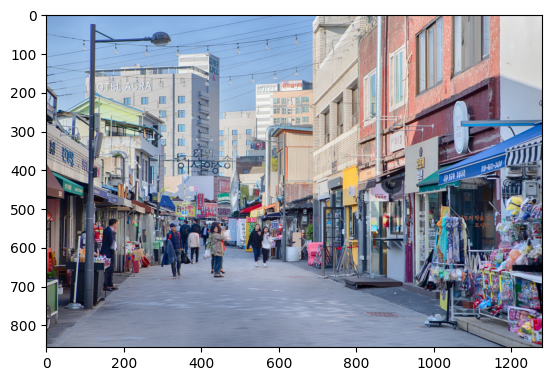

In [5]:
# Hyper Parameter
generate_kwargs = {
    'max_length': 100,
    'do_sample' : False, #
    'early_stopping' : True,
    'num_beams' : 1,
    'temperature' : 1.0,
    'top_k': 50,
    'top_p': 1.0,
    'repetition_penalty' : 1.0,
    'no_repeat_ngram_size' : 0,
    'num_return_sequences' : 1,
    'use_cache' : True,
}
# Generate
with torch.no_grad():
    res = model.generate(**inputs, **generate_kwargs)
sentence = tokenizer.decode(res.tolist()[0], skip_special_tokens=True)

img = Image.open(image_list[0])
plt.imshow(img)

print(sentence)

In [75]:
for i in sentence.split(","):
    if i[0] == " ":
        print(i[1:])
    else:
        print(i)

The image depicts a bustling city street filled with shops and people
creating a vibrant and lively atmosphere. #citylife
#shoppingdistrict
#bustlingcity
#citystreets
#busycity
#vibrantcity
and #livelycity are suitable hashtags for this image.


# Inference Function

In [48]:
def get_hashtag(image_path, prompt, generate_kwargs):

    # Prompt
    prompts = [
    f'''The following is a conversation between a curious human and AI assistant. The assistant gives helpful, detailed, and polite answers to the user's questions.
    Human: <image>
    Human: {prompt}
    AI: ''']

    # Image
    image_list = [f"{image_path}"]

    # Preprocessing
    images = [Image.open(_) for _ in image_list]
    inputs = processor(text=prompts, images=images, return_tensors='pt')
    inputs = {k: v.bfloat16() if v.dtype == torch.float else v for k, v in inputs.items()}
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # Generate
    with torch.no_grad():
        res = model.generate(**inputs, **generate_kwargs)
    sentence = tokenizer.decode(res.tolist()[0], skip_special_tokens=True)
    
    return sentence, generate_kwargs

# Get Hashtag

In [49]:
# [parameter]
model.to("cuda:2")

prompt = "Please create 7 hashtags for Instagram through a sentence that summarizes the image in one sentence. Only hashtags are shown in the output, and separated by commas."

with open("/home/livin/rimo/genAI/meta_data.json", "r") as file:
    data = json.load(file)

image_folder = "/home/livin/rimo/genAI/test_images"

In [50]:
with open("/home/livin/rimo/genAI/meta_data.json", "r") as file:
    data = json.load(file)
generate_kwargs = {
    'max_length': 100,
    'do_sample' : False, #
    'early_stopping' : True,
    'num_beams' : 1,
    'temperature' : 1.0,
    'top_k': 50,
    'top_p': 1.0,
    'repetition_penalty' : 1.0,
    'no_repeat_ngram_size' : 0,
    'num_return_sequences' : 1,
    'use_cache' : True,
}
# inference 
for i in tqdm(range(len(data))):
    image_path = os.path.join(image_folder,data[str(i)]["image_path"])
    data[str(i)]["result"] = get_hashtag(image_path, prompt, generate_kwargs)
data["args"] = generate_kwargs
data = json.dumps(data, ensure_ascii=False)
arg_name = generate_kwargs["repetition_penalty"]
with open(f"/home/livin/rimo/genAI/result/prompt_2.json", "w") as file:
    file.write(data)

100%|██████████| 50/50 [01:48<00:00,  2.17s/it]


In [52]:
prompt

'From the sentence summarizing the image, please create 7 hashtags for Instagram. Make sure that each hashtag is not similar to each other'

In [51]:
with open("/home/livin/rimo/genAI/meta_data.json", "r") as file:
    data = json.load(file)
generate_kwargs = {
    'max_length': 100,
    'do_sample' : False, #
    'early_stopping' : True,
    'num_beams' : 1,
    'temperature' : 1.0,
    'top_k': 50,
    'top_p': 1.0,
    'repetition_penalty' : 2.0,
    'no_repeat_ngram_size' : 0,
    'num_return_sequences' : 1,
    'use_cache' : True,
}
# inference 
for i in tqdm(range(len(data))):
    image_path = os.path.join(image_folder,data[str(i)]["image_path"])
    data[str(i)]["result"] = get_hashtag(image_path, prompt, generate_kwargs)
data["args"] = generate_kwargs
data = json.dumps(data, ensure_ascii=False)
arg_name = generate_kwargs["repetition_penalty"]
with open(f"/home/livin/rimo/genAI/result/result_RP-{arg_name}.json", "w") as file:
    file.write(data)

100%|██████████| 50/50 [02:11<00:00,  2.64s/it]


In [ ]:
with open("/home/livin/rimo/genAI/meta_data.json", "r") as file:
    data = json.load(file)
generate_kwargs = {
    'max_length': 100,
    'do_sample' : False, #
    'early_stopping' : True,
    'num_beams' : 1,
    'temperature' : 1.0,
    'top_k': 50,
    'top_p': 1.0,
    'repetition_penalty' : 3.0,
    'no_repeat_ngram_size' : 0,
    'num_return_sequences' : 1,
    'use_cache' : True,
}
# inference 
for i in tqdm(range(len(data))):
    image_path = os.path.join(image_folder,data[str(i)]["image_path"])
    data[str(i)]["result"] = get_hashtag(image_path, prompt, generate_kwargs)
data["args"] = generate_kwargs
data = json.dumps(data, ensure_ascii=False)
arg_name = generate_kwargs["repetition_penalty"]
with open(f"/home/livin/rimo/genAI/result/result_RP-{arg_name}.json", "w") as file:
    file.write(data)

In [ ]:
with open("/home/livin/rimo/genAI/meta_data.json", "r") as file:
    data = json.load(file)
generate_kwargs = {
    'max_length': 100,
    'do_sample' : False, #
    'early_stopping' : True,
    'num_beams' : 1,
    'temperature' : 1.0,
    'top_k': 50,
    'top_p': 1.0,
    'repetition_penalty' : 4.0,
    'no_repeat_ngram_size' : 0,
    'num_return_sequences' : 1,
    'use_cache' : True,
}
# inference 
for i in tqdm(range(len(data))):
    image_path = os.path.join(image_folder,data[str(i)]["image_path"])
    data[str(i)]["result"] = get_hashtag(image_path, prompt, generate_kwargs)
data["args"] = generate_kwargs
data = json.dumps(data, ensure_ascii=False)
arg_name = generate_kwargs["repetition_penalty"]
with open(f"/home/livin/rimo/genAI/result/result_RP-{arg_name}.json", "w") as file:
    file.write(data)

In [ ]:
with open("/home/livin/rimo/genAI/meta_data.json", "r") as file:
    data = json.load(file)
generate_kwargs = {
    'max_length': 100,
    'do_sample' : False, #
    'early_stopping' : True,
    'num_beams' : 1,
    'temperature' : 1.0,
    'top_k': 50,
    'top_p': 1.0,
    'repetition_penalty' : 5.0,
    'no_repeat_ngram_size' : 0,
    'num_return_sequences' : 1,
    'use_cache' : True,
}
# inference 
for i in tqdm(range(len(data))):
    image_path = os.path.join(image_folder,data[str(i)]["image_path"])
    data[str(i)]["result"] = get_hashtag(image_path, prompt, generate_kwargs)
data["args"] = generate_kwargs
data = json.dumps(data, ensure_ascii=False)
arg_name = generate_kwargs["repetition_penalty"]
with open(f"/home/livin/rimo/genAI/result/result_RP-{arg_name}.json", "w") as file:
    file.write(data)

In [ ]:
with open("/home/livin/rimo/genAI/meta_data.json", "r") as file:
    data = json.load(file)
generate_kwargs = {
    'max_length': 100,
    'do_sample' : False, #
    'early_stopping' : True,
    'num_beams' : 1,
    'temperature' : 1.0,
    'top_k': 50,
    'top_p': 1.0,
    'repetition_penalty' : 10.0,
    'no_repeat_ngram_size' : 0,
    'num_return_sequences' : 1,
    'use_cache' : True,
}
# inference 
for i in tqdm(range(len(data))):
    image_path = os.path.join(image_folder,data[str(i)]["image_path"])
    data[str(i)]["result"] = get_hashtag(image_path, prompt, generate_kwargs)
data["args"] = generate_kwargs
data = json.dumps(data, ensure_ascii=False)
arg_name = generate_kwargs["repetition_penalty"]
with open(f"/home/livin/rimo/genAI/result/result_RP-{arg_name}.json", "w") as file:
    file.write(data)

In [ ]:
with open("/home/livin/rimo/genAI/meta_data.json", "r") as file:
    data = json.load(file)
generate_kwargs = {
    'max_length': 100,
    'do_sample' : False, #
    'early_stopping' : True,
    'num_beams' : 1,
    'temperature' : 1.0,
    'top_k': 50,
    'top_p': 1.0,
    'repetition_penalty' : 20.0,
    'no_repeat_ngram_size' : 0,
    'num_return_sequences' : 1,
    'use_cache' : True,
}
# inference 
for i in tqdm(range(len(data))):
    image_path = os.path.join(image_folder,data[str(i)]["image_path"])
    data[str(i)]["result"] = get_hashtag(image_path, prompt, generate_kwargs)
data["args"] = generate_kwargs
data = json.dumps(data, ensure_ascii=False)
arg_name = generate_kwargs["repetition_penalty"]
with open(f"/home/livin/rimo/genAI/result/result_RP-{arg_name}.json", "w") as file:
    file.write(data)

In [ ]:
with open("/home/livin/rimo/genAI/meta_data.json", "r") as file:
    data = json.load(file)
generate_kwargs = {
    'max_length': 100,
    'do_sample' : False, #
    'early_stopping' : True,
    'num_beams' : 1,
    'temperature' : 1.0,
    'top_k': 50,
    'top_p': 1.0,
    'repetition_penalty' : 30.0,
    'no_repeat_ngram_size' : 0,
    'num_return_sequences' : 1,
    'use_cache' : True,
}
# inference 
for i in tqdm(range(len(data))):
    image_path = os.path.join(image_folder,data[str(i)]["image_path"])
    data[str(i)]["result"] = get_hashtag(image_path, prompt, generate_kwargs)
data["args"] = generate_kwargs
data = json.dumps(data, ensure_ascii=False)
arg_name = generate_kwargs["repetition_penalty"]
with open(f"/home/livin/rimo/genAI/result/result_RP-{arg_name}.json", "w") as file:
    file.write(data)

In [ ]:
with open("/home/livin/rimo/genAI/meta_data.json", "r") as file:
    data = json.load(file)
generate_kwargs = {
    'max_length': 100,
    'do_sample' : False, #
    'early_stopping' : True,
    'num_beams' : 1,
    'temperature' : 1.0,
    'top_k': 50,
    'top_p': 1.0,
    'repetition_penalty' : 50.0,
    'no_repeat_ngram_size' : 0,
    'num_return_sequences' : 1,
    'use_cache' : True,
}
# inference 
for i in tqdm(range(len(data))):
    image_path = os.path.join(image_folder,data[str(i)]["image_path"])
    data[str(i)]["result"] = get_hashtag(image_path, prompt, generate_kwargs)
data["args"] = generate_kwargs
data = json.dumps(data, ensure_ascii=False)
arg_name = generate_kwargs["repetition_penalty"]
with open(f"/home/livin/rimo/genAI/result/result_RP-{arg_name}.json", "w") as file:
    file.write(data)